# SAT4 VGG16 Image Classification
## Anthony Ayon,  George Hong, Alan Mai, Gryffan Palmer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np

# Model imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import backend as K
import tensorflow as tf

# importing
from pandas import read_csv

# preprocessing
import scipy.ndimage

Using TensorFlow backend.


In [0]:
# pretrained vgg with imagenet, own input layer
def sat4_vgg16(img_shape, num_classes, optimizer, freeze_layers = True):
    """
    VGG16 with transfer learned weights from ImageNet. The last two FC layers are
    untrained.
    Args:
        image_shape: the shape of the image, channel_last data format.
        num_classes: the number of classifier classes.
        optimizer: optimizer used for the model.
        freeze_layers: boolean on whether to freeze the imagenet layer weights.
    Return:
        Untrained Keras model instance
    """
    
    # FIXME: THIS SHOULD DEFAULT TO CHANNEL_LAST. IF NOT WE'RE (Not really) FUCKED
    
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    #model_vgg16_conv.summary()
    
    # freeze the vgg layers
    if (freeze_layers):
        for layer in model_vgg16_conv.layers:
            layer.trainable = False
    
    #Create your own input format
    img_input = Input(shape=img_shape, name='image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(img_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=img_input, outputs=x)
    pretrained_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return pretrained_model

In [0]:
def sat4_preprocess_data(X):    
    # reshape to channel last
    # zoom to 56, 56, 4
    X = X.reshape(X.shape[0], 28, 28, 4)
    X = scipy.ndimage.zoom(X, (1,2,2,1), order=0)
    # try using 1,8,8,1
    # or 1,2,2,1

    # slice out near infrared channel
    X_rgb = X[:,:,:,:3]
    X_nir = np.stack((X[:,:,:,3],)*3, axis=-1) # duplicate along 3 channels
        
    return X_rgb, X_nir

In [8]:
import datetime
# This is the section for the complete file read in batch sizes

X_shape = (56,56,3)
# if 1,8,8,1 use (224,224,3)
# if 1,2,2,1 use (56,56,3)
classes = 4
# classes
optimizer = Adam(lr=0.0001)
model_rgb = sat4_vgg16(X_shape, classes, optimizer)
model_nir = sat4_vgg16(X_shape, classes, optimizer)

start = datetime.datetime.now().time()

# drastically reduced chunk_size for bigger picture.
chunk_size = 40000
file_name_X = '/content/drive/Team Drives/COGS 118B Final Project/X_train_sat4.csv'
file_name_Y = '/content/drive/Team Drives/COGS 118B Final Project/y_train_sat4.csv'

for i in range(6): # manual Epochs
    print("Epoch #",i+1)
    for X_batch, Y_batch in zip(
        read_csv(file_name_X, chunksize=chunk_size),
        read_csv(file_name_Y, chunksize=chunk_size)
    ):
        X_train_rgb, X_train_nir = sat4_preprocess_data(X_batch.values.astype('float32'))
        X_train_rgb = preprocess_input(X_train_rgb)
        X_train_nir = preprocess_input(X_train_nir)
        model_rgb.fit(X_train_rgb, Y_batch, batch_size=256, verbose=1)
        model_nir.fit(X_train_nir, Y_batch, batch_size=256, verbose=1)

end = datetime.datetime.now().time()
print("End Time = ",end)
print("Start Time = ",start)

Epoch # 1
Epoch 1/1
40000/40000 [==============================] - 36s 912us/step - loss: 0.4146 - acc: 0.8851
Epoch 1/1
40000/40000 [==============================] - 32s 801us/step - loss: 0.6694 - acc: 0.8242
Epoch 1/1
40000/40000 [==============================] - 31s 782us/step - loss: 0.2166 - acc: 0.9355
Epoch 1/1
40000/40000 [==============================] - 31s 778us/step - loss: 0.3256 - acc: 0.8745
Epoch 1/1
40000/40000 [==============================] - 31s 780us/step - loss: 0.1751 - acc: 0.9458
Epoch 1/1
40000/40000 [==============================] - 31s 777us/step - loss: 0.2728 - acc: 0.8932
Epoch 1/1
40000/40000 [==============================] - 31s 782us/step - loss: 0.1476 - acc: 0.9531
Epoch 1/1
40000/40000 [==============================] - 31s 779us/step - loss: 0.2587 - acc: 0.8968
Epoch 1/1
40000/40000 [==============================] - 31s 781us/step - loss: 0.1310 - acc: 0.9581
Epoch 1/1
40000/40000 [==============================] - 31s 785us/step - loss: 0

In [9]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:             12          11           0           0           1           9
Swap:             0           0           0


In [0]:
def combine_scores(yhat1, yhat2, alpha):
    """
    Args:
        yhat1:
        yhat2:
        alpha: weighting of yhat1
    """
    return np.add(alpha * yhat1, (1-alpha) * yhat2)

In [0]:
# from keras before they were removed for only being calculated batchwise
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fbeta_score(true_positives, predicted_positives, possible_positives, beta):
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    bb = beta ** 2
    return (1 + bb) * (p * r) / ((bb * p) + r + K.epsilon())
    
def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

def num_true_positives(y_true, y_pred):
    return K.sum(K.round(K.clip(tf.math.multiply(y_true, y_pred), 0, 1)))

def num_predicted_positives(y_pred):
    return K.sum(K.round(K.clip(y_pred, 0, 1)))

def num_possible_positives(y_true):
    return K.sum(K.round(K.clip(y_true, 0, 1)))

In [12]:
# Get test acc in chunks
iters = 0
chunk_size = 2500

loss_rgb = 0
acc_rgb = 0
loss_nir = 0
acc_nir = 0
loss_both = 0
acc_both = 0

test_X = '/content/drive/Team Drives/COGS 118B Final Project/X_test_sat4.csv'
test_Y = '/content/drive/Team Drives/COGS 118B Final Project/y_test_sat4.csv'

yhat_rgb = []
yhat_nir = []
yhat_both = []

indices_true = np.array([])
indices_rgb = np.array([])
indices_nir = np.array([])
indices_both = np.array([])

for X_batch, Y_batch in zip(
  read_csv(test_X,chunksize = chunk_size),
  read_csv(test_Y,chunksize = chunk_size)
):
    X_test_rgb, X_test_nir = sat4_preprocess_data(X_batch.values.astype('float32'))
    X_test_rgb = preprocess_input(X_test_rgb)
    X_test_nir = preprocess_input(X_test_nir)  
    
    # individual model loss/acc
    temp_loss, temp_acc = model_rgb.evaluate(X_test_rgb,Y_batch,batch_size = 32)
    loss_rgb = loss_rgb + temp_loss
    acc_rgb = acc_rgb + temp_acc
   
    temp_loss, temp_acc = model_nir.evaluate(X_test_nir,Y_batch,batch_size = 32)
    loss_nir = loss_nir + temp_loss
    acc_nir = acc_nir + temp_acc
    
    # late fusion model loss/acc
    yhat_rgb = model_rgb.predict(X_test_rgb)
    yhat_nir = model_nir.predict(X_test_nir)
  
    yhat_rgb = K.eval(tf.one_hot(tf.argmax(yhat_rgb, axis = 1), depth = 4, dtype=tf.float64))
    yhat_nir = K.eval(tf.one_hot(tf.argmax(yhat_nir, axis = 1), depth = 4, dtype=tf.float64))

    # add to confusion matrix here for rgb, nir
    indices_rgb = np.concatenate((indices_rgb, np.argmax(yhat_rgb, axis=1).flatten()))
    indices_nir = np.concatenate((indices_nir, np.argmax(yhat_nir, axis=1).flatten()))
    
    # add y_true to confusion matrix of both
    indices_true = np.concatenate((indices_true, np.argmax(Y_batch.values, axis=1).flatten()))
    
    Y_batch = tf.cast(tf.convert_to_tensor(Y_batch), tf.float64)
    
    yhat_both = combine_scores(yhat_rgb, yhat_nir, 0.5)
    yhat_both = tf.one_hot(tf.argmax(yhat_both, axis = 1), depth = 4, dtype=tf.float64)
    
    temp_loss = K.eval(K.mean(categorical_crossentropy(Y_batch, yhat_both)))
    temp_acc = K.eval(K.mean(categorical_accuracy(Y_batch, yhat_both)))
    loss_both = loss_both + temp_loss
    acc_both = acc_both + temp_acc
    
    yhat_both = K.eval(yhat_both)
    
    # add to confusion matrix of both
    indices_both = np.concatenate((indices_both, np.argmax(yhat_both, axis=1).flatten()))

    iters = iters + 1
    



2499/2499 [==============================] - 3s 1ms/step


In [13]:


acc_rgb = acc_rgb / iters # this is slightly off right now b/c iterations are 2500 2500 ... 25000 2499
loss_rgb = loss_rgb / iters
acc_nir = acc_nir / iters
loss_nir = loss_nir / iters
acc_both = acc_both / iters
loss_both = loss_both / iters

print("acc_rgb is ", acc_rgb)
print("loss_rgb is ", loss_rgb)

print("acc_nir is ", acc_nir)
print("loss_nir is ", loss_nir)

print("acc_both is ", acc_both)
print("loss_both is ", loss_both)


acc_rgb is  0.987849879951981
loss_rgb is  0.03480338928148407
acc_nir is  0.9582296358543415
loss_nir is  0.1055431517578874
acc_both is  0.9739297583699227
loss_both is  0.4202027209043752


In [14]:
confusion_mat_rgb = np.zeros((4,4))
confusion_mat_nir = np.zeros((4,4))
confusion_mat_both = np.zeros((4,4))

indices_true = indices_true.astype(int)
indices_rgb = indices_rgb.astype(int)
indices_nir = indices_nir.astype(int)
indices_both = indices_both.astype(int)


for i in range(len(indices_true)):
    col = indices_true[i]
    confusion_mat_rgb[indices_rgb[i]][col] += 1
    confusion_mat_nir[indices_nir[i]][col] += 1
    confusion_mat_both[indices_both[i]][col] += 1

print(confusion_mat_rgb)
print(confusion_mat_nir)
print(confusion_mat_both)

[[2.5913e+04 2.2000e+01 3.2000e+02 8.8000e+01]
 [2.8000e+01 2.0129e+04 2.7700e+02 6.4000e+01]
 [2.2900e+02 6.0000e+01 1.7293e+04 3.3000e+01]
 [1.8000e+01 2.0000e+01 5.6000e+01 3.5449e+04]]
[[24088.    48.  1262.    98.]
 [   57. 19954.   200.   116.]
 [ 1962.   133. 16437.    77.]
 [   81.    96.    47. 35343.]]
[[2.6070e+04 6.9000e+01 1.5510e+03 1.7800e+02]
 [1.4000e+01 2.0150e+04 4.1100e+02 1.6600e+02]
 [1.0300e+02 1.2000e+01 1.5980e+04 9.8000e+01]
 [1.0000e+00 0.0000e+00 4.0000e+00 3.5192e+04]]


[[2.5723e+04 3.8000e+01 2.6100e+02 5.2000e+01]
 [1.4000e+01 2.0030e+04 2.0500e+02 2.6000e+01]
 [4.0100e+02 1.2200e+02 1.7408e+04 5.2000e+01]
 [5.0000e+01 4.1000e+01 7.2000e+01 3.5504e+04]]
[[24521.    59.  2233.   150.]
 [   70. 19882.   191.   107.]
 [ 1531.   161. 15458.   111.]
 [   66.   129.    64. 35266.]]
[[2.6022e+04 9.5000e+01 2.4450e+03 1.9400e+02]
 [1.1000e+01 2.0119e+04 3.2900e+02 1.2500e+02]
 [1.5100e+02 1.4000e+01 1.5166e+04 1.5300e+02]
 [4.0000e+00 3.0000e+00 6.0000e+00 3.5162e+04]]

In [0]:
# Get F scores
def f1scores(mat):
    true_positive = np.ones(4)
    false_positive = np.ones(4)
    false_negative = np.ones(4)
    recall = np.ones(4)
    precision = np.ones(4)
    f_vals = np.ones(4)

    # get true positives
    for i in range(4):
        true_positive[i] = mat[i][i]

    # get false positive
    for i in range(4):
        for j in range(4):
            if i == j:
                continue
            false_positive[i] = false_positive[i] + mat[i][j]

    # get false negative
    for i in range(4):
        for j in range(4):
            if i == j:
                continue
            false_negative[i] = false_negative[i] + mat[j][i]

    # get precision
    for i in range(4):
        precision[i] = true_positive[i]/(true_positive[i]+false_positive[i])

    # get recall
    for i in range(4):
        recall[i] = true_positive[i]/(true_positive[i]+false_negative[i])

    # get f_vals
    for i in range(4):
        f_vals[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])

    # model f_val is average
    f_avg = np.sum(f_vals)/4

    print("F1 Scores = ",f_vals)
    print("Average F1 = ",f_avg)
    
    return f_vals, f_avg

In [16]:
f_vals_rgb, f_avg_rgb = f1scores(confusion_mat_rgb)
f_vals_nir, f_avg_nir = f1scores(confusion_mat_nir)
f_vals_both, f_avg_both = f1scores(confusion_mat_both)

F1 Scores =  [0.98654179 0.98838722 0.97252763 0.99605221]
Average F1 =  0.9858772124264662
F1 Scores =  [0.93208993 0.98392505 0.89925322 0.99273907]
Average F1 =  0.9520018169824994
F1 Scores =  [0.96451959 0.98355054 0.93611786 0.99366115]
Average F1 =  0.9694622862774483


F1 Scores =  [0.98434869 0.98894046 0.9689683  0.99586273]
Average F1 =  0.9845300436232217
F1 Scores =  [0.92265723 0.98223946 0.87807095 0.99116089]
Average F1 =  0.9435321324428252
F1 Scores =  [0.94718451 0.98581473 0.90727447 0.99312254]
Average F1 =  0.9583490618795468

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion_mat(mat, title):
    # print the confusion matrix
    plt.figure()
    mat = mat.astype('float') / mat.sum(axis=0)[:, np.newaxis]
    y_labels = ["Predict Barren","Predict Trees","Predict Grassland","Predict Other"]
    x_labels = ["True Barren","True Trees","True Grassland","True Other"]
    sns.heatmap(mat,annot = True,fmt = '.5f',yticklabels=y_labels,xticklabels =x_labels)
    plt.title(title)

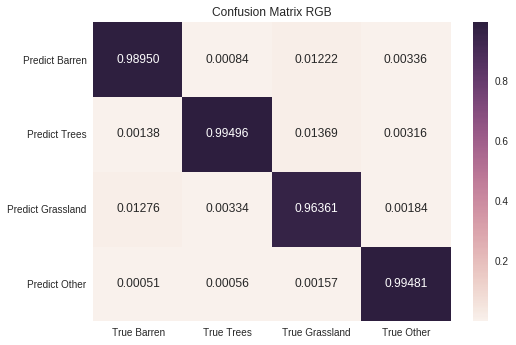

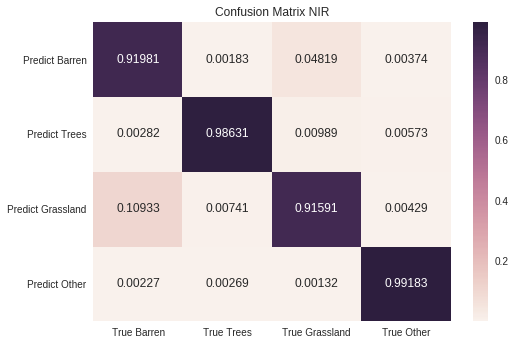

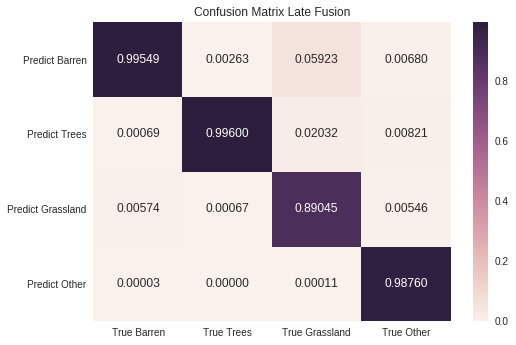

In [18]:
draw_confusion_mat(confusion_mat_rgb, "Confusion Matrix RGB")
draw_confusion_mat(confusion_mat_nir, "Confusion Matrix NIR")
draw_confusion_mat(confusion_mat_both, "Confusion Matrix Late Fusion")

In [19]:
print(model_rgb.history)

In [23]:
# Plot Accuracy
accuracy = model.fit(...)
print(model_rgb.history.keys())
plt.plot(model_rgb.history()['acc'])
plt.plot(model_rgb.history()['val_acc'])
#plt.title('Batch 32, Epochs 8 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Plot Loss
# plt.plot(accuracy.history['loss'])
# plt.plot(accuracy.history['val_loss'])
# plt.title('Batch 32, Epochs 8 Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.show()

TypeError: ignored